In [1]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from plotnine import *
import seaborn as sns

import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_score, train_test_split

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

import statsmodels.api as sm

import rulefit

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

print('\nok')


ok


In [2]:
# sensitivity:
# min ref_length > 10; < 100
# max n_authors of 50
# cited_by_count > 10; < 100

# by publication year
# solo; 2-author

In [3]:
raw_df = pd.read_feather('data/analysis_df.feather').set_index('id')
raw_df

,is_retracted,publication_year,cited_by_count,ref_length,journal_id,journal_name,n_authors,abstract_indexed,has_doi,has_pmid,concept0,concept1,disrupt,focal_refs,len_I,len_J,novelty_title,novelty_abstract,n_citing
id,,,,,,,,,,,,,,,,,,,
W1000085140,0,2015,8,21,V17140621,Clinical Biochemistry,8,1,1,1,Medicine,None,0.000000,21.0,4.0,4.0,NaN,NaN,8.0
W1000238170,0,2015,23,34,V2764928002,Redox biology,7,1,1,1,Chemistry,Cell biology,0.629630,34.0,22.0,5.0,1.083342,0.644107,27.0
W1000402150,0,2015,1,1,V2764481192,Procedia. Economics and finance,4,1,1,0,Business,None,1.000000,1.0,1.0,0.0,NaN,NaN,1.0
W10005641,0,2013,40,47,V188605413,Carbon,7,1,1,0,None,Optoelectronics,-0.459459,47.0,10.0,27.0,NaN,NaN,37.0
W1000768039,0,2015,50,32,V127530304,Journal of Materials Processing Technology,5,1,1,0,None,None,0.000000,32.0,25.0,25.0,NaN,NaN,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
W99822253,1,2012,4,3,V125754415,Proceedings of the National Academy of Science...,7,0,1,1,Medicine,Immunology,1.000000,3.0,3.0,0.0,NaN,NaN,3.0
W998644059,0,2015,4,47,V186231457,Agroforestry Systems,3,1,1,0,Geography,Socioeconomics,-0.500000,47.0,1.0,3.0,NaN,NaN,4.0
W998753227,0,2015,16,38,V186231457,Agroforestry Systems,3,1,1,0,None,None,-0.333333,38.0,6.0,12.0,NaN,NaN,18.0


In [4]:
X_names = 'is_retracted publication_year cited_by_count ref_length n_authors'.split()
Y_names = 'novelty_title novelty_abstract disrupt'.split()
wanted_columns = Y_names + X_names
# df = df[df.disrupt.notna()]
df = raw_df[wanted_columns].copy()
df

,novelty_title,novelty_abstract,disrupt,is_retracted,publication_year,cited_by_count,ref_length,n_authors
id,,,,,,,,
W1000085140,NaN,NaN,0.000000,0,2015,8,21,8
W1000238170,1.083342,0.644107,0.629630,0,2015,23,34,7
W1000402150,NaN,NaN,1.000000,0,2015,1,1,4
W10005641,NaN,NaN,-0.459459,0,2013,40,47,7
W1000768039,NaN,NaN,0.000000,0,2015,50,32,5
...,...,...,...,...,...,...,...,...
W99822253,NaN,NaN,1.000000,1,2012,4,3,7
W998644059,NaN,NaN,-0.500000,0,2015,4,47,3
W998753227,NaN,NaN,-0.333333,0,2015,16,38,3


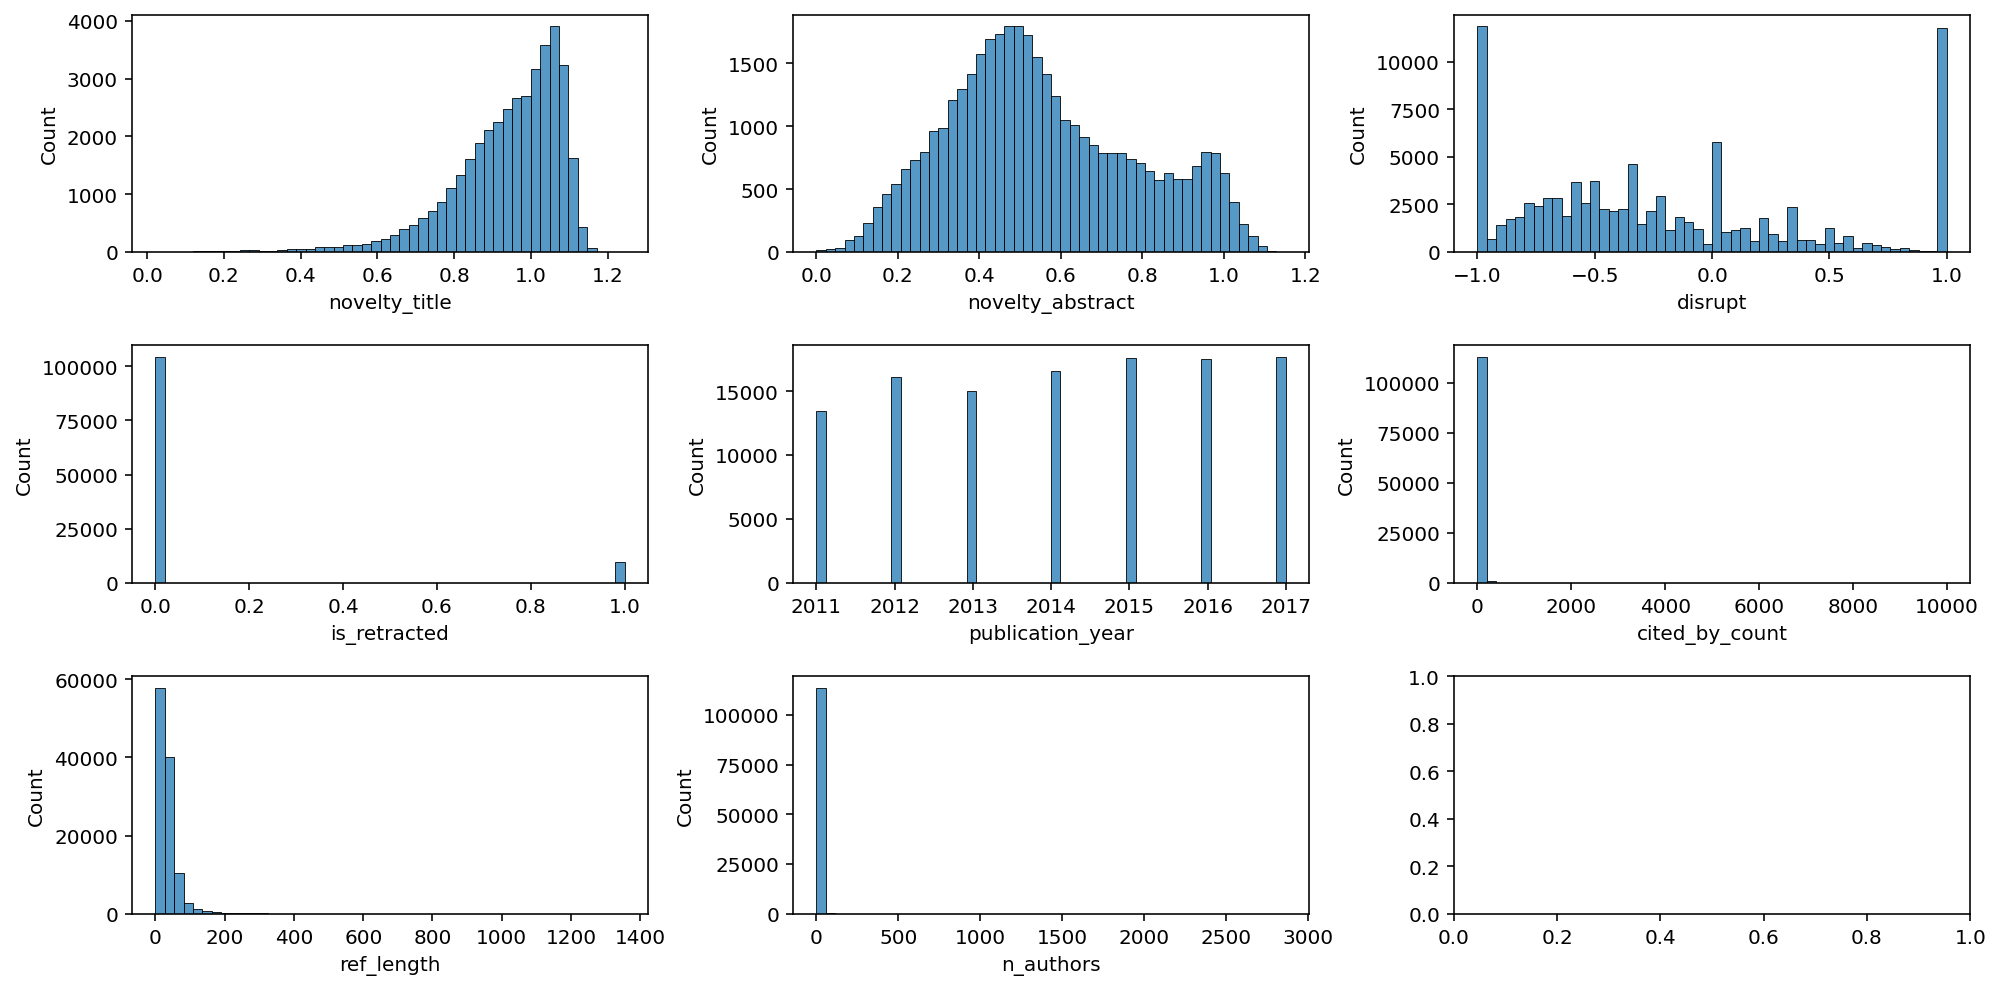

In [5]:
fig, axes = plt.subplots(3, 3, figsize=(14, 7))
for c, ax in zip(df.columns, axes.flat):
    sns.histplot(df[c], bins=50, ax=ax)
plt.tight_layout()

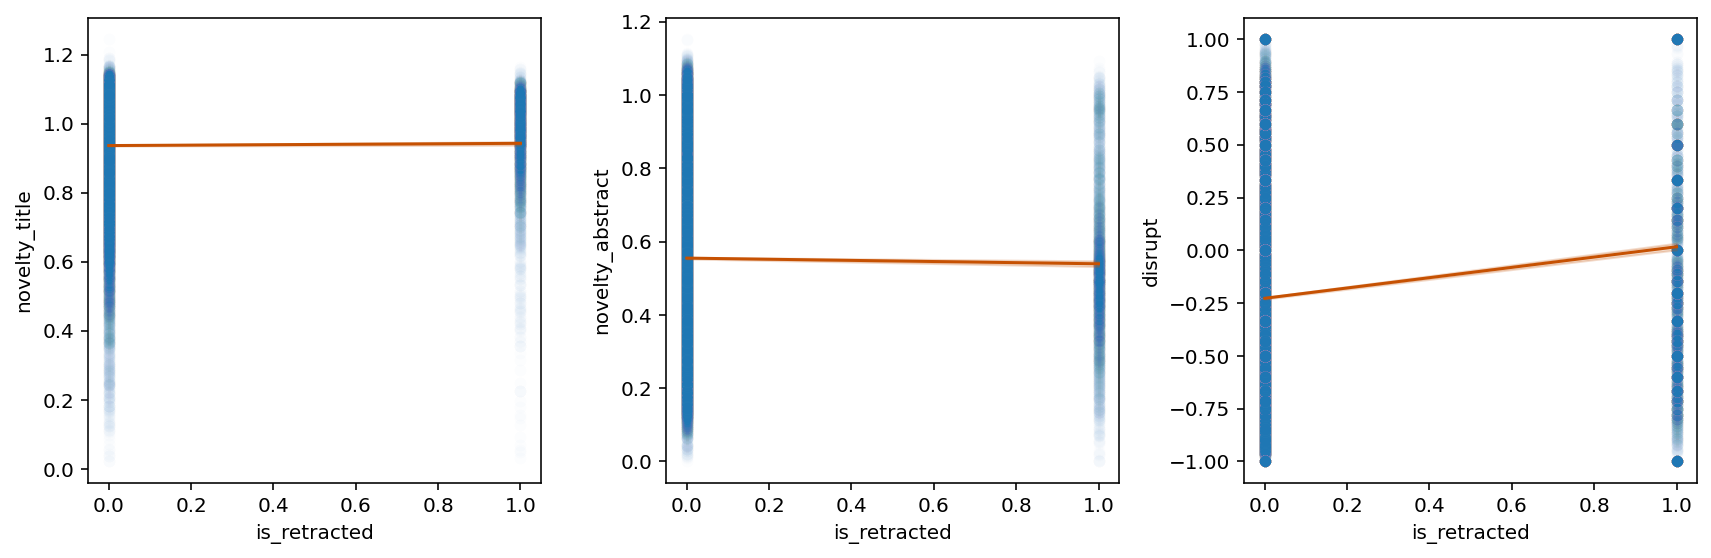

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for var, ax in zip(Y_names, axes.flat):
    sns.scatterplot(data=df, x='is_retracted', y=var, alpha=0.01, ax=ax)
    sns.lineplot(data=df, x='is_retracted', y=var, color='#c65102', ax=ax)
plt.tight_layout()
plt.show()

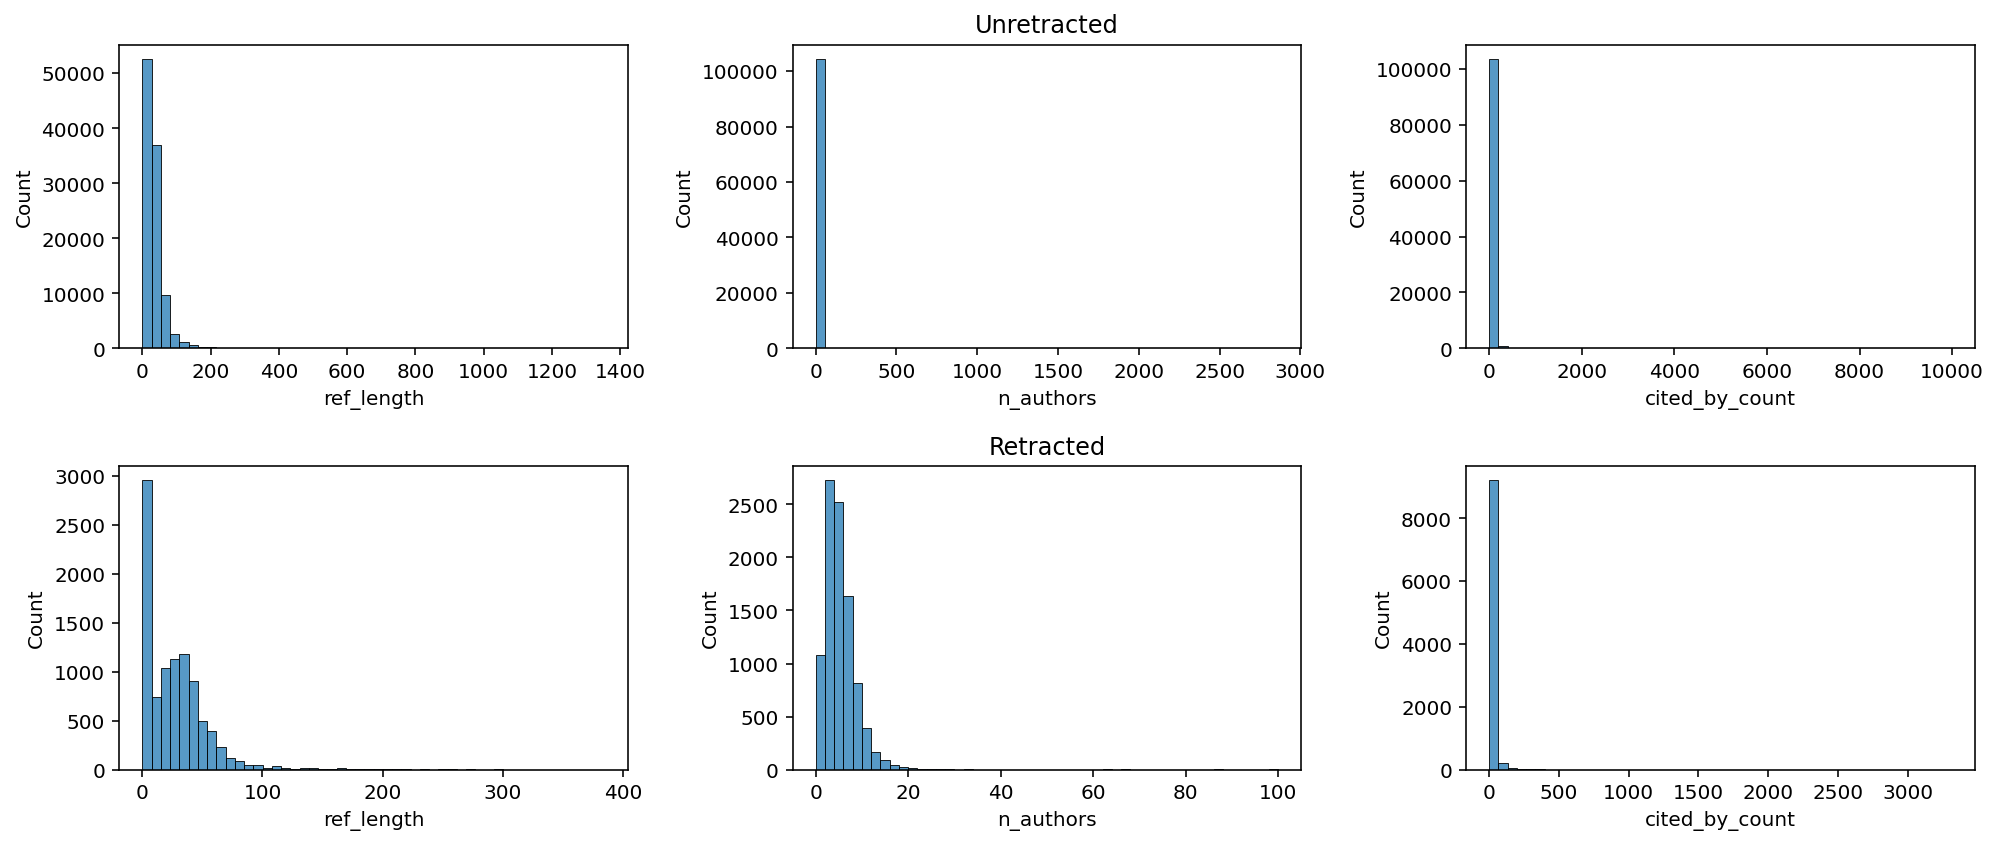

In [7]:
fig, axes = plt.subplots(2, 3, figsize=(14, 6))
for val in (0, 1):
    for c, ax in zip(['ref_length', 'n_authors', 'cited_by_count'], axes[val]):
        sns.histplot(df[df.is_retracted == val][c], bins=50, ax=ax)
axes[0][1].set_title("Unretracted")
axes[1][1].set_title("Retracted")
plt.tight_layout()


# model selection

In [8]:
df[(df.is_retracted == True) & df.disrupt.notna()]['ref_length'].describe()

count    6810.000000
mean       32.810866
std        28.918440
min         0.000000
25%        15.000000
50%        30.000000
75%        44.000000
max       317.000000
Name: ref_length, dtype: float64

In [9]:
df[(df.is_retracted == False) & df.disrupt.notna()]['ref_length'].describe()

count    90528.000000
mean        36.057783
std         32.315861
min          0.000000
25%         18.000000
50%         31.000000
75%         46.000000
max       1355.000000
Name: ref_length, dtype: float64

novelty_title
[(0.0071167125113606984, 0.0025947029178970482), (0.0004314446970129338, 5.089264384251972e-06), (4.527966372287482e-06, 4.96647376678596e-05), (0.0018055690860915856, 0.00011494865067580039), (0.00018900138414842442, 0.0019791452763459495)]
                                 OLS Regression Results                                
Dep. Variable:          novelty_title   R-squared (uncentered):                   0.981
Model:                            OLS   Adj. R-squared (uncentered):              0.981
Method:                 Least Squares   F-statistic:                          3.943e+05
Date:                Thu, 11 Aug 2022   Prob (F-statistic):                        0.00
Time:                        23:18:20   Log-Likelihood:                          23558.
No. Observations:               39019   AIC:                                 -4.711e+04
Df Residuals:                   39014   BIC:                                 -4.706e+04
Df Model:                           5   

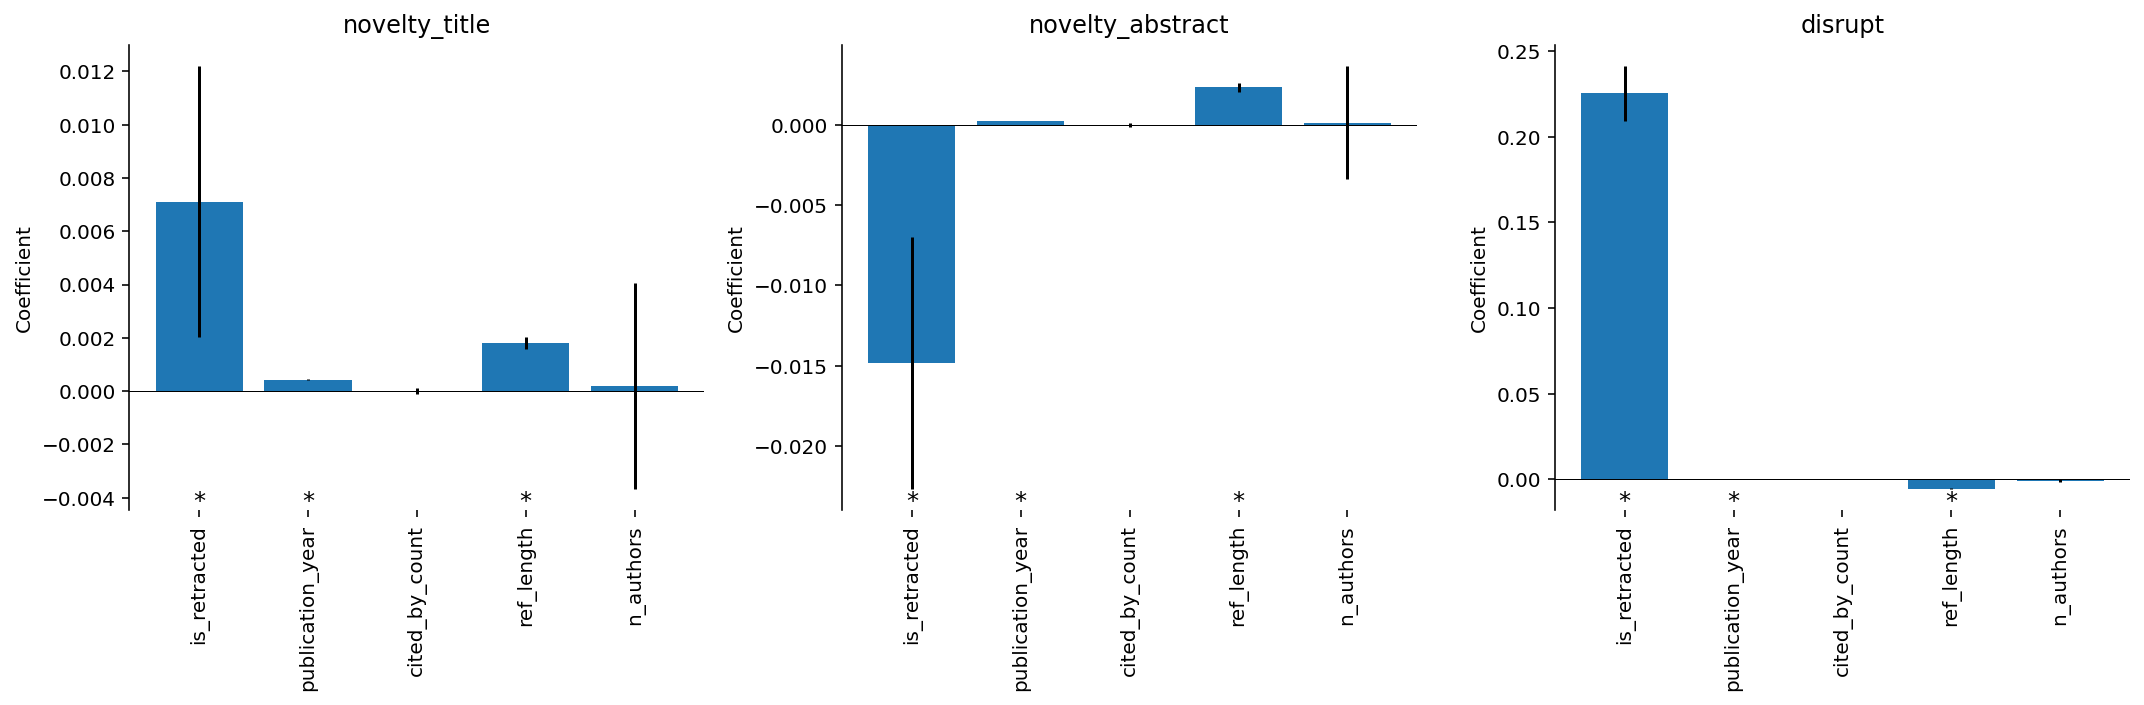

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=False)

for i, y_name in enumerate(Y_names):
    ols_df = df.copy()
    ols_df = ols_df[ols_df[y_name].notna()]
    y = ols_df[y_name]
    X = ols_df[X_names]
    print(y_name)
    ols = sm.OLS(y, X)
    ols_result = ols.fit(cov_type='HC3')
    print(list(zip(ols_result.params, ols_result.HC3_se))) #, ols_result.conf_int()

#     ols_err = (ols_result.conf_int()[1] - ols_result.conf_int()[0])
    ols_err = ols_result.HC3_se*1.96
    print(ols_result.summary())
    axes[i].bar(X_names, ols_result.params, yerr=ols_err) #, color='#999')
    
    ymin, ymax = axes[i].get_ylim()
    ynudge = (ymax-ymin)/50
    print(ymin)
    for x, label in enumerate('*' if p < .05 else '' for p in ols_result.pvalues):
        axes[i].text(x=x, y=ymin+ynudge, s=label, size=12, ha='center', va='center')
    axes[i].set_title(y_name)
#     axes[0,1].bar(X_names, ols_model.coef_, color='#999')
#     axes[0,1].set_ylabel("Linear Regression")
for i, ax in enumerate(fig.axes):
    plt.sca(ax)
#     plt.ylim(-.05,.28)
    plt.xticks(rotation=90)
    ax.set_ylabel("Coefficient")
    sns.despine(bottom=True)
    plt.axhline(0, color='#000', lw=0.5)
# fig.suptitle("Traditional OLS Results")
fig.tight_layout() # blows out figsize with suptitle
plt.show()    